In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import xgboost as xgb
from sklearn import model_selection, preprocessing
color = sns.color_palette()
%matplotlib inline

def num2log(arr):
    return np.log(arr + 1)
# result retransform
def log2num(arr):
    return np.exp(arr) - 1
# treat date
def trans_date(arr): 
    return datetime.datetime.strptime(arr, '%Y-%m-%d').date()

data = pd.read_csv('C:/Users/JP/Documents/School/Practicum/Github/Practicum/data/dataset.csv')

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df = df.set_index('Date')
df=df[df.index>'2017-05-30']
df.head()

,ETHOpen,ETHHigh,ETHLow,volumeto,volumefrom,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue
Date,,,,,,,,,,,,
2017-05-31,228.58,233.92,214.05,2.257407e+08,1010028.21,153.87500,97.410,2.200,4.3,0.83,18569.1,2415.9
2017-06-01,228.64,235.52,208.00,1.887444e+08,855293.22,154.68750,97.135,1.872,4.3,0.91,18569.1,2411.0
2017-06-02,220.70,227.71,216.94,8.963579e+07,407207.46,154.96875,96.740,1.872,4.4,0.91,18569.1,2413.1
2017-06-03,222.04,226.41,218.79,5.593801e+07,253020.73,154.90625,96.960,1.872,4.4,0.91,18569.1,2429.6
2017-06-04,224.30,249.34,223.88,1.236961e+08,519826.47,154.90625,96.960,1.872,4.4,0.91,18569.1,2429.6


In [17]:
train_df = df[df.index<'2017-09-01']

train_df.head()

,ETHOpen,ETHHigh,ETHLow,volumeto,volumefrom,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue
Date,,,,,,,,,,,,
2017-05-31,228.58,233.92,214.05,2.257407e+08,1010028.21,153.87500,97.410,2.200,4.3,0.83,18569.1,2415.9
2017-06-01,228.64,235.52,208.00,1.887444e+08,855293.22,154.68750,97.135,1.872,4.3,0.91,18569.1,2411.0
2017-06-02,220.70,227.71,216.94,8.963579e+07,407207.46,154.96875,96.740,1.872,4.4,0.91,18569.1,2413.1
2017-06-03,222.04,226.41,218.79,5.593801e+07,253020.73,154.90625,96.960,1.872,4.4,0.91,18569.1,2429.6
2017-06-04,224.30,249.34,223.88,1.236961e+08,519826.47,154.90625,96.960,1.872,4.4,0.91,18569.1,2429.6


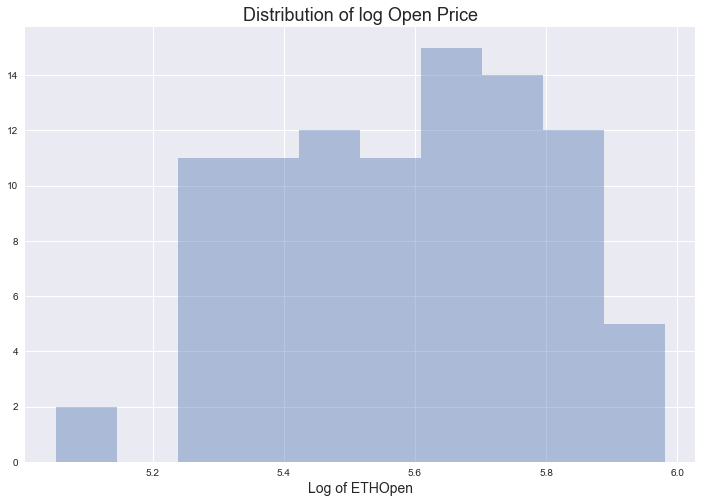

In [3]:
plt.figure(figsize=(12,8))
sns.distplot(num2log(train_df.ETHOpen.values), bins=10, kde=False)
plt.xlabel('Log of ETHOpen', fontsize=14)
plt.title('Distribution of log Open Price', fontsize = 18)
plt.show()

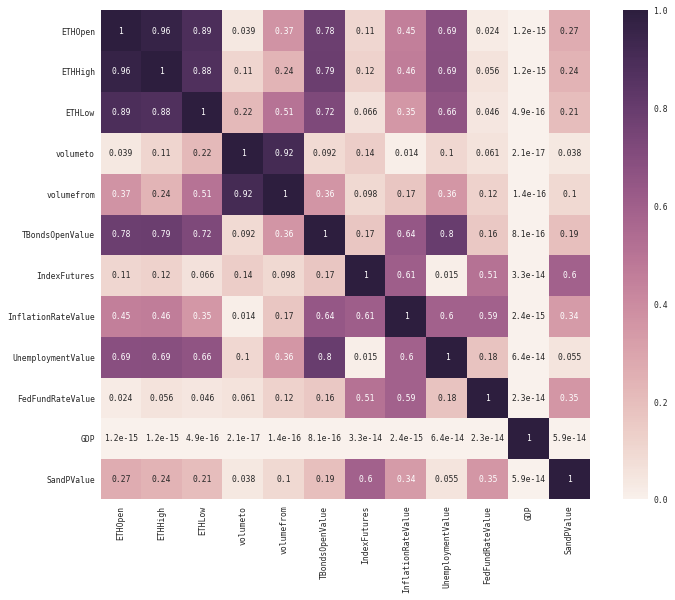

In [4]:
corrmat = train_df.corr(method='pearson')
corrmat = np.abs(corrmat)
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1,annot=True, square=True, xticklabels = True, yticklabels = True, 
            annot_kws={'size': 8})

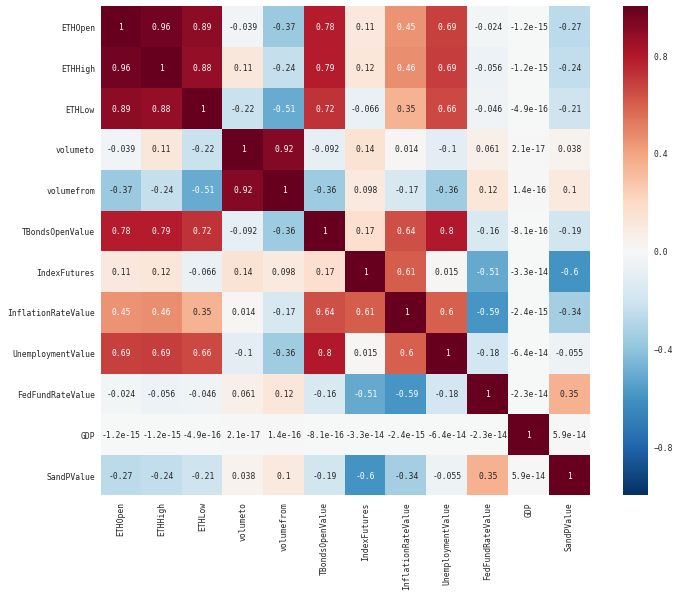

In [5]:
corrmat = train_df.corr(method='pearson')

sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1,vmin=-1,annot=True, square=True, xticklabels = True, yticklabels = True, 
            annot_kws={'size': 8})

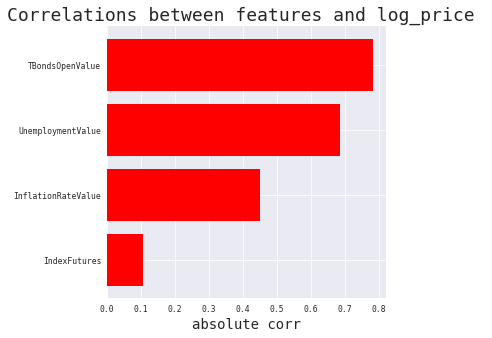

In [6]:
remain_num = 10
#train_df['logETHOpen'] = num2log(train_df.ETHOpen.values)
corr_target = corrmat['ETHOpen'].reset_index()[3:]
corr_target.columns = ['feature','abs_corr']
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)[:remain_num].loc[corr_target['abs_corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(5,5))
rects = ax.barh(ind, corr_target.abs_corr.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 14)
ax.set_title("Correlations between features and log_price ", fontsize = 18)
plt.show()


In [7]:
df.tail()

,ETHOpen,ETHHigh,ETHLow,volumeto,volumefrom,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue
Date,,,,,,,,,,,,
2017-10-12,302.86,308.77,301.65,1.303575e+08,426811.81,152.1875,92.705,2.233,4.2,1.16,18569.1,2548.4
2017-10-13,302.89,347.70,298.29,3.251308e+08,994746.99,152.4375,92.435,2.233,4.2,NaN,18569.1,2552.1
2017-10-14,336.83,347.14,333.83,1.182179e+08,345894.16,153.1250,92.565,2.233,4.2,NaN,18569.1,2547.8
2017-10-15,338.81,341.93,318.35,1.540462e+08,465975.53,153.1250,92.565,2.233,4.2,NaN,18569.1,2547.8
2017-10-16,336.58,337.18,335.69,1.916019e+06,5697.18,NaN,NaN,NaN,NaN,NaN,18569.1,NaN


In [18]:
import json
import requests
import pandas as pd

from pandas.io.json import json_normalize



response = requests.get("https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&allData=TRUE")


data = json.loads(response.text)
data2 = json_normalize(data)
json_data = data['Data']
df2=pd.DataFrame(data['Data'])
df2['time'] = pd.to_datetime(df2['time'],unit='s')
df2['Date'] = pd.to_datetime(df2['time'],unit='s')
BTC = df2[['Date','open']]
BTC['BTCOpen']=BTC['open']
BTC=BTC[['Date','BTCOpen']]
BTC.tail()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date,BTCOpen
798,2017-10-13,302.89
799,2017-10-14,336.83
800,2017-10-15,338.81
801,2017-10-16,336.58
802,2017-10-17,334.23


In [19]:
df=df[df.index>'2017-05-30']
df['Date'] = df.index.values
dataset = pd.merge(df, BTC, on='Date')
dataset.tail()

,ETHOpen,ETHHigh,ETHLow,volumeto,volumefrom,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue,Date,BTCOpen
134,302.86,308.77,301.65,1.303575e+08,426811.81,152.1875,92.705,2.233,4.2,1.16,18569.1,2548.4,2017-10-12,302.86
135,302.89,347.70,298.29,3.251308e+08,994746.99,152.4375,92.435,2.233,4.2,NaN,18569.1,2552.1,2017-10-13,302.89
136,336.83,347.14,333.83,1.182179e+08,345894.16,153.1250,92.565,2.233,4.2,NaN,18569.1,2547.8,2017-10-14,336.83
137,338.81,341.93,318.35,1.540462e+08,465975.53,153.1250,92.565,2.233,4.2,NaN,18569.1,2547.8,2017-10-15,338.81
138,336.58,337.18,335.69,1.916019e+06,5697.18,NaN,NaN,NaN,NaN,NaN,18569.1,NaN,2017-10-16,336.58


In [20]:
dataset['ETHOpenTM1'] = dataset['ETHOpen'].shift(1)
dataset['ETHOpenTM2'] = dataset['ETHOpen'].shift(2)
dataset['ETHOpenTM3'] = dataset['ETHOpen'].shift(3)
dataset['ETHOpenTM4'] = dataset['ETHOpen'].shift(4)
dataset['ETHOpenTM5'] = dataset['ETHOpen'].shift(5)
dataset['ETHOpenTM6'] = dataset['ETHOpen'].shift(6)
dataset['ETHOpenTM7'] = dataset['ETHOpen'].shift(7)
dataset['BTCOpenTM1'] = dataset['BTCOpen'].shift(1)
dataset['BTCOpenTM2'] = dataset['BTCOpen'].shift(2)
dataset['BTCOpenTM3'] = dataset['BTCOpen'].shift(3)
dataset['BTCOpenTM4'] = dataset['BTCOpen'].shift(4)
dataset['BTCOpenTM5'] = dataset['BTCOpen'].shift(5)
dataset['BTCOpenTM6'] = dataset['BTCOpen'].shift(6)
dataset['BTCOpenTM7'] = dataset['BTCOpen'].shift(7)
dataset['PrevHigh'] = dataset['ETHHigh'].shift(1)
dataset['PrevHigh2'] = dataset['ETHHigh'].shift(2)
dataset['PrevHigh3'] = dataset['ETHHigh'].shift(3)
dataset['PrevHigh4'] = dataset['ETHHigh'].shift(4)
dataset['PrevLow'] = dataset['ETHLow'].shift(1)
dataset['PrevLow2'] = dataset['ETHLow'].shift(2)
dataset['PrevLow3'] = dataset['ETHLow'].shift(3)
dataset['PrevLow4'] = dataset['ETHLow'].shift(4)
dataset['PrevVolTo'] = dataset['volumeto'].shift(1)
dataset['PrevVolTo2'] = dataset['volumeto'].shift(2)
dataset['PrevVolTo3'] = dataset['volumeto'].shift(3)
dataset['PrevVolTo4'] = dataset['volumeto'].shift(4)
dataset['PrevVolFrom'] = dataset['volumefrom'].shift(1)
dataset['PrevVolFrom2'] = dataset['volumefrom'].shift(2)
dataset['PrevVolFrom3'] = dataset['volumefrom'].shift(3)
dataset['PrevVolFrom4'] = dataset['volumefrom'].shift(4)
dataset['PrevSP'] = dataset['SandPValue'].shift(1)
dataset['PrevSP2'] = dataset['SandPValue'].shift(2)
dataset['PrevSP3'] = dataset['SandPValue'].shift(3)
dataset['PrevSP4'] = dataset['SandPValue'].shift(4)


dataset.head()

,ETHOpen,ETHHigh,ETHLow,volumeto,volumefrom,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,...,PrevVolTo3,PrevVolTo4,PrevVolFrom,PrevVolFrom2,PrevVolFrom3,PrevVolFrom4,PrevSP,PrevSP2,PrevSP3,PrevSP4
0,228.58,233.92,214.05,2.257407e+08,1010028.21,153.87500,97.410,2.200,4.3,0.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,228.64,235.52,208.00,1.887444e+08,855293.22,154.68750,97.135,1.872,4.3,0.91,...,NaN,NaN,1010028.21,NaN,NaN,NaN,2415.9,NaN,NaN,NaN
2,220.70,227.71,216.94,8.963579e+07,407207.46,154.96875,96.740,1.872,4.4,0.91,...,NaN,NaN,855293.22,1010028.21,NaN,NaN,2411.0,2415.9,NaN,NaN
3,222.04,226.41,218.79,5.593801e+07,253020.73,154.90625,96.960,1.872,4.4,0.91,...,2.257407e+08,NaN,407207.46,855293.22,1010028.21,NaN,2413.1,2411.0,2415.9,NaN
4,224.30,249.34,223.88,1.236961e+08,519826.47,154.90625,96.960,1.872,4.4,0.91,...,1.887444e+08,2.257407e+08,253020.73,407207.46,855293.22,1010028.21,2429.6,2413.1,2411.0,2415.9


In [21]:
dataset.to_csv('C:/Users/JP/Documents/School/Practicum/Github/Practicum/data/dataset2.csv',index=False)


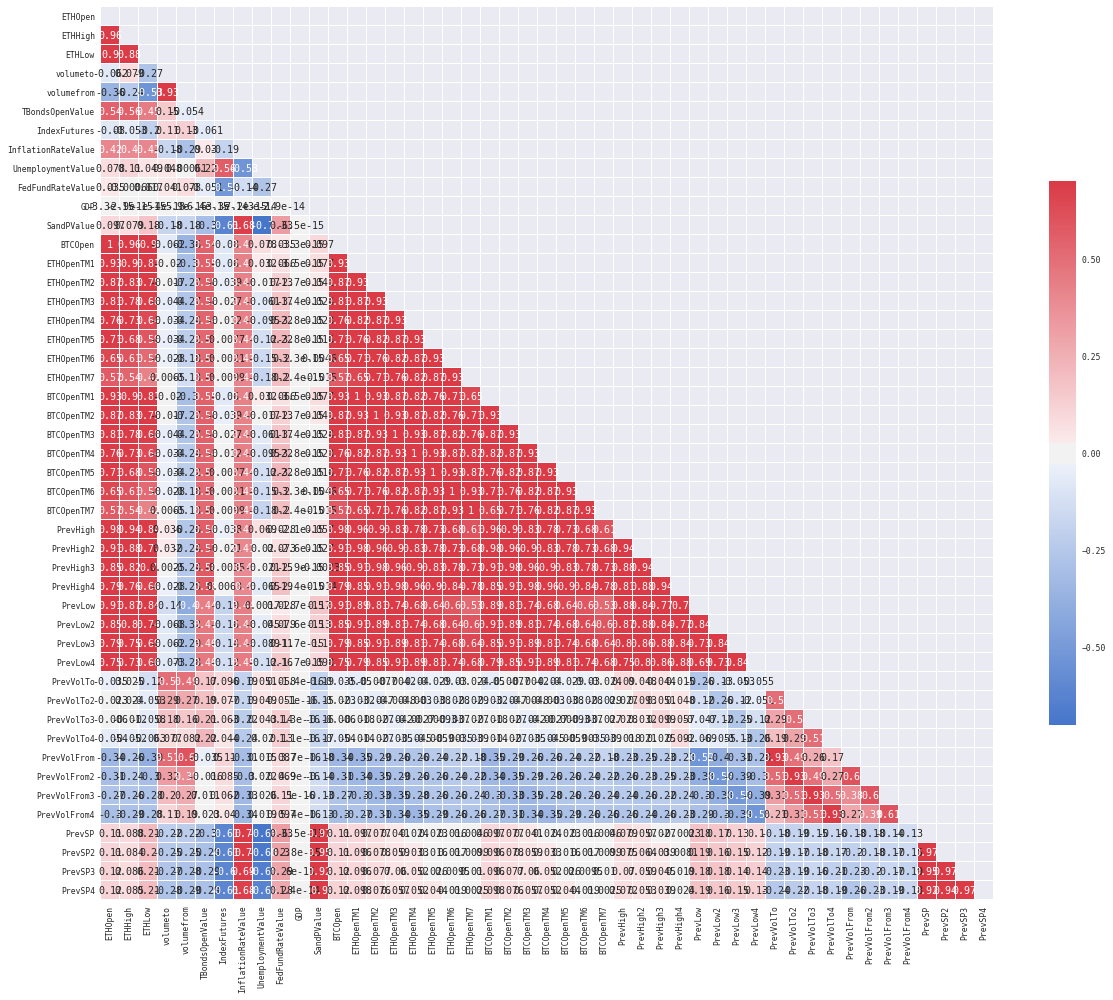

In [22]:
corr = dataset.corr(method='pearson')
#corrmat = np.abs(corrmat)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True



cmap = sns.diverging_palette(255, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,xticklabels = True, yticklabels = True, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

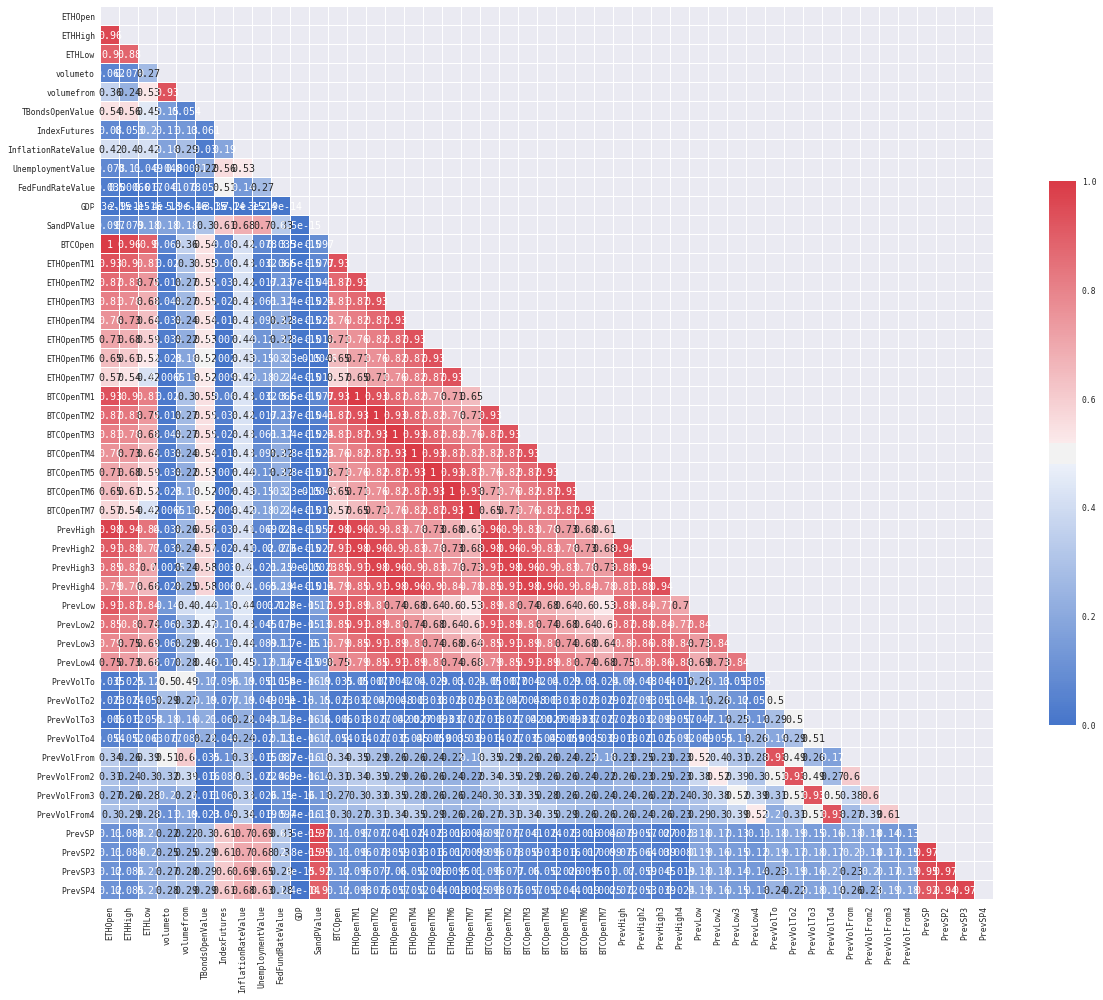

In [23]:
corr = dataset.corr(method='pearson')
corr = np.abs(corr)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=.5,xticklabels = True, yticklabels = True, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

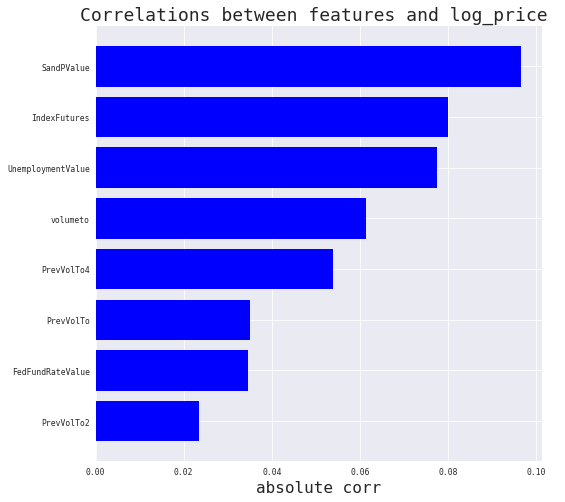

In [24]:
corr_target = corr['ETHOpen'].reset_index()[3:]
corr_target.columns = ['feature','abs_corr']
corr_target = corr_target.sort_values(by = 'abs_corr', ascending = True)[:remain_num].loc[corr_target['abs_corr'] >0.01]
ind = np.arange(corr_target.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(8,8))
rects = ax.barh(ind, corr_target.abs_corr.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_target.feature.values, rotation='horizontal')
ax.set_xlabel("absolute corr", fontsize = 16)
ax.set_title("Correlations between features and log_price ", fontsize = 18)
plt.show()

In [74]:
Logset = dataset

In [76]:
Logset['ETHOpen'] = np.log(Logset['ETHOpen'])
Logset['ETHHigh'] = np.log(Logset['ETHHigh'])
Logset['ETHLow'] = np.log(Logset['ETHLow'])
Logset['TBondsOpenValue'] = np.log(Logset['TBondsOpenValue'])
Logset['InflationRateValue'] = np.log(Logset['InflationRateValue'])
Logset['IndexFutures'] = np.log(Logset['IndexFutures'])
Logset['UnemploymentValue'] = np.log(Logset['UnemploymentValue'])
Logset['FedFundRateValue'] = np.log(Logset['FedFundRateValue'])
Logset['GDP'] = np.log(Logset['GDP'])
Logset['SandPValue'] = np.log(Logset['SandPValue'])
Logset['ETHOpenTM1'] = np.log(Logset['ETHOpenTM1'])
Logset['ETHOpenTM2'] = np.log(Logset['ETHOpenTM2']) 
Logset['ETHOpenTM3'] = np.log(Logset['ETHOpenTM3']) 
Logset['ETHOpenTM4'] = np.log(Logset['ETHOpenTM4']) 
Logset['ETHOpenTM5'] = np.log(Logset['ETHOpenTM5']) 
Logset['ETHOpenTM6'] = np.log(Logset['ETHOpenTM6']) 
Logset['ETHOpenTM7'] = np.log(Logset['ETHOpenTM7']) 
Logset['BTCOpenTM1'] = np.log(Logset['BTCOpenTM1']) 
Logset['BTCOpenTM2'] = np.log(Logset['BTCOpenTM2']) 
Logset['BTCOpenTM3'] = np.log(Logset['BTCOpenTM3']) 
Logset['BTCOpenTM4'] = np.log(Logset['BTCOpenTM4'])
Logset['BTCOpenTM5'] = np.log(Logset['BTCOpenTM5']) 
Logset['BTCOpenTM6'] = np.log(Logset['BTCOpenTM6'])
Logset['BTCOpenTM7'] = np.log(Logset['BTCOpenTM7'])
Logset = Logset.set_index('Date')


In [78]:
Logset.head()

,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue,...,ETHOpenTM5,ETHOpenTM6,ETHOpenTM7,BTCOpenTM1,BTCOpenTM2,BTCOpenTM3,BTCOpenTM4,BTCOpenTM5,BTCOpenTM6,BTCOpenTM7
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-31,5.431886,5.454979,5.366210,5.041407,4.576102,0.788457,1.458615,-0.186330,9.829254,7.787797,...,5.501095,5.512420,5.576933,5.431886,5.432149,5.432149,5.396804,5.501095,5.512420,5.576933
2017-05-31,5.431886,5.454979,5.366210,5.041407,4.576102,0.627007,1.458615,-0.186330,9.829254,7.787797,...,5.512420,5.576933,5.544279,5.432149,5.432149,5.396804,5.501095,5.512420,5.576933,5.544279
2017-06-01,5.432149,5.461796,5.337538,5.043223,4.572027,0.627007,1.458615,-0.094311,9.829254,7.788668,...,5.576933,5.544279,5.558410,5.432149,5.396804,5.501095,5.512420,5.576933,5.544279,5.558410
2017-06-01,5.432149,5.461796,5.337538,5.043223,4.572027,0.627007,1.481605,-0.094311,9.829254,7.788668,...,5.544279,5.558410,5.828004,5.396804,5.501095,5.512420,5.576933,5.544279,5.558410,5.828004
2017-06-02,5.396804,5.428073,5.379621,5.042820,4.574299,0.627007,1.481605,-0.094311,9.829254,7.795482,...,5.558410,5.828004,5.978025,5.501095,5.512420,5.576933,5.544279,5.558410,5.828004,5.978025


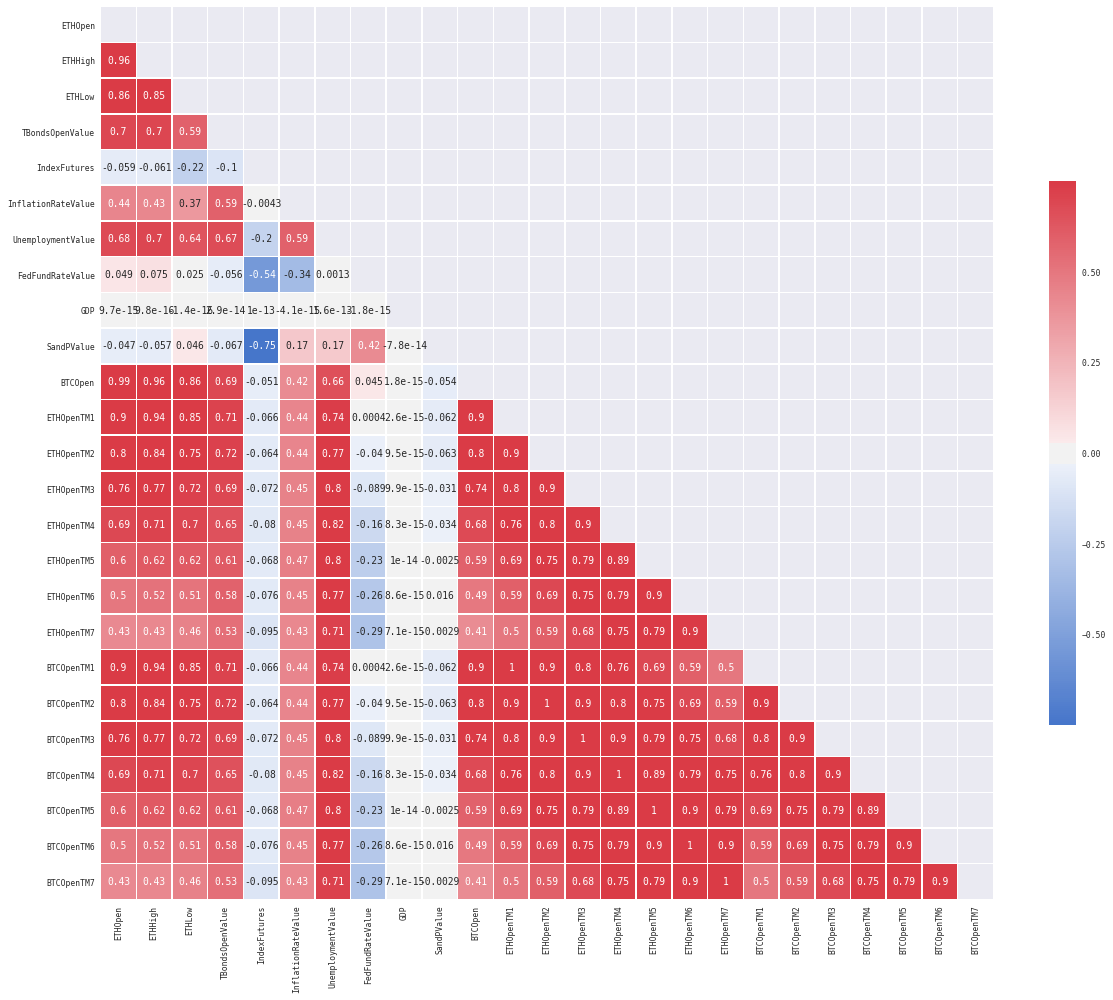

In [79]:
 
corr = Logset.corr(method='pearson')
#corrmat = np.abs(corrmat)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True



cmap = sns.diverging_palette(255, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,xticklabels = True, yticklabels = True, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [84]:
Logset['Date'] = Logset.index

In [82]:
Logset.to_csv('C:/Users/JP/Documents/School/Practicum/Github/Practicum/data/dataset3.csv',index=False)

In [83]:
Logset

,ETHOpen,ETHHigh,ETHLow,TBondsOpenValue,IndexFutures,InflationRateValue,UnemploymentValue,FedFundRateValue,GDP,SandPValue,...,ETHOpenTM6,ETHOpenTM7,BTCOpenTM1,BTCOpenTM2,BTCOpenTM3,BTCOpenTM4,BTCOpenTM5,BTCOpenTM6,BTCOpenTM7,Date
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-31,5.431886,5.454979,5.366210,5.041407,4.576102,0.788457,1.458615,-0.186330,9.829254,7.787797,...,5.512420,5.576933,5.431886,5.432149,5.432149,5.396804,5.501095,5.512420,5.576933,2017-05-31
2017-05-31,5.431886,5.454979,5.366210,5.041407,4.576102,0.627007,1.458615,-0.186330,9.829254,7.787797,...,5.576933,5.544279,5.432149,5.432149,5.396804,5.501095,5.512420,5.576933,5.544279,2017-05-31
2017-06-01,5.432149,5.461796,5.337538,5.043223,4.572027,0.627007,1.458615,-0.094311,9.829254,7.788668,...,5.544279,5.558410,5.432149,5.396804,5.501095,5.512420,5.576933,5.544279,5.558410,2017-06-01
2017-06-01,5.432149,5.461796,5.337538,5.043223,4.572027,0.627007,1.481605,-0.094311,9.829254,7.788668,...,5.558410,5.828004,5.396804,5.501095,5.512420,5.576933,5.544279,5.558410,5.828004,2017-06-01
2017-06-02,5.396804,5.428073,5.379621,5.042820,4.574299,0.627007,1.481605,-0.094311,9.829254,7.795482,...,5.828004,5.978025,5.501095,5.512420,5.576933,5.544279,5.558410,5.828004,5.978025,2017-06-02
2017-06-05,5.501095,5.515926,5.486869,5.051657,4.569232,0.627007,1.481605,-0.094311,9.829254,7.797291,...,5.978025,5.961237,5.512420,5.576933,5.544279,5.558410,5.828004,5.978025,5.961237,2017-06-05
2017-06-06,5.512420,5.591435,5.507362,5.047851,4.569906,0.627007,1.481605,-0.094311,9.829254,7.796880,...,5.961237,5.840176,5.576933,5.544279,5.558410,5.828004,5.978025,5.961237,5.840176,2017-06-06
2017-06-07,5.576933,5.578975,5.506022,5.052257,4.567624,0.627007,1.481605,-0.094311,9.829254,7.796428,...,5.840176,5.842616,5.544279,5.558410,5.828004,5.978025,5.961237,5.840176,5.842616,2017-06-07
2017-06-08,5.544279,5.563639,5.525015,5.048252,4.569077,0.627007,1.481605,-0.094311,9.829254,7.796223,...,5.842616,5.862295,5.558410,5.828004,5.978025,5.961237,5.840176,5.842616,5.862295,2017-06-08
